# Using SWOT satellite altimetry

This example will guide you through each step required to estimate energy cascade rates from a single SWOT KaRIn swath.

**General procedure**

1. Load and visualize the SWOT sea surface height anomaly (SSHA) data
2. Use SSHA to estimate geostrophic velocities
3. Subset the data to a small region
4. Calculate various structure functions from the geostrophic velocities in the subset region
5. Estimate cascade rates from the structure functions
6. Plot cascade rates
7. Plot 2nd order structure functions

In [7]:
import matplotlib_inline.backend_inline
import seaborn as sns

sns.set_style(style="white")
sns.set_context("talk")

matplotlib_inline.backend_inline.set_matplotlib_formats("png", dpi=200)

## Load the SWOT NetCDF file and visualize the data

We will use `xarray` to load the `.nc` file. We are using the Expert version of SWOT Level-3 LR SSH v1.0, available through AVISO. This version includes estimates of geostrophic velocity along with improved data post-processing. It is possible to estimate geostrophic velocities from SSH data only, which is available in the Basic version of Level-3 and Level-2. 

**_Note:_** The SWOT data is not provided in the FluidSF repository, so you must instead access the data through [PO.DAAC](https://podaac.jpl.nasa.gov/SWOT?tab=mission-objectives&sections=about%2Bdata), [AVISO](https://www.aviso.altimetry.fr/en/data/products/sea-surface-height-products/global.html), or other methods. This example uses L3 data, accessible through AVISO.

In [8]:
import xarray as xr

# Provide the path to the SWOT data you have downloaded
ds = xr.open_dataset('example_data/SWOT_L3_LR_SSH_Expert_SAMPLE.nc') 

In [9]:
ds

<xarray.Dataset>
Dimensions:               (num_lines: 9860, num_pixels: 69, num_nadir: 1631)
Coordinates:
    latitude              (num_lines, num_pixels) float64 ...
    longitude             (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/18)
    time                  (num_lines) datetime64[ns] ...
    mdt                   (num_lines, num_pixels) float64 ...
    ssha                  (num_lines, num_pixels) float64 ...
    ssha_noiseless        (num_lines, num_pixels) float64 ...
    ssha_unedited         (num_lines, num_pixels) float64 ...
    quality_flag          (num_lines, num_pixels) uint8 ...
    ...                    ...
    ugosa                 (num_lines, num_pixels) float64 ...
    vgosa                 (num_lines, num_pixels) float64 ...
    sigma0                (num_lines, num_pixels) float64 ...
    cross_track_distance  (num_pixels) float64 ...
    i_num_line            (num_nadir) int16 ...
    i_num_pixel           (num_nadir) int8 ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    geospatial_lat_min:              -78.272196
    geospatial_lat_max:              78.272247
    geospatial_lon_min:              0.000835
    geospatial_lon_max:              359.99901
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...

## Plot the SSH anomaly data with and without noise removal

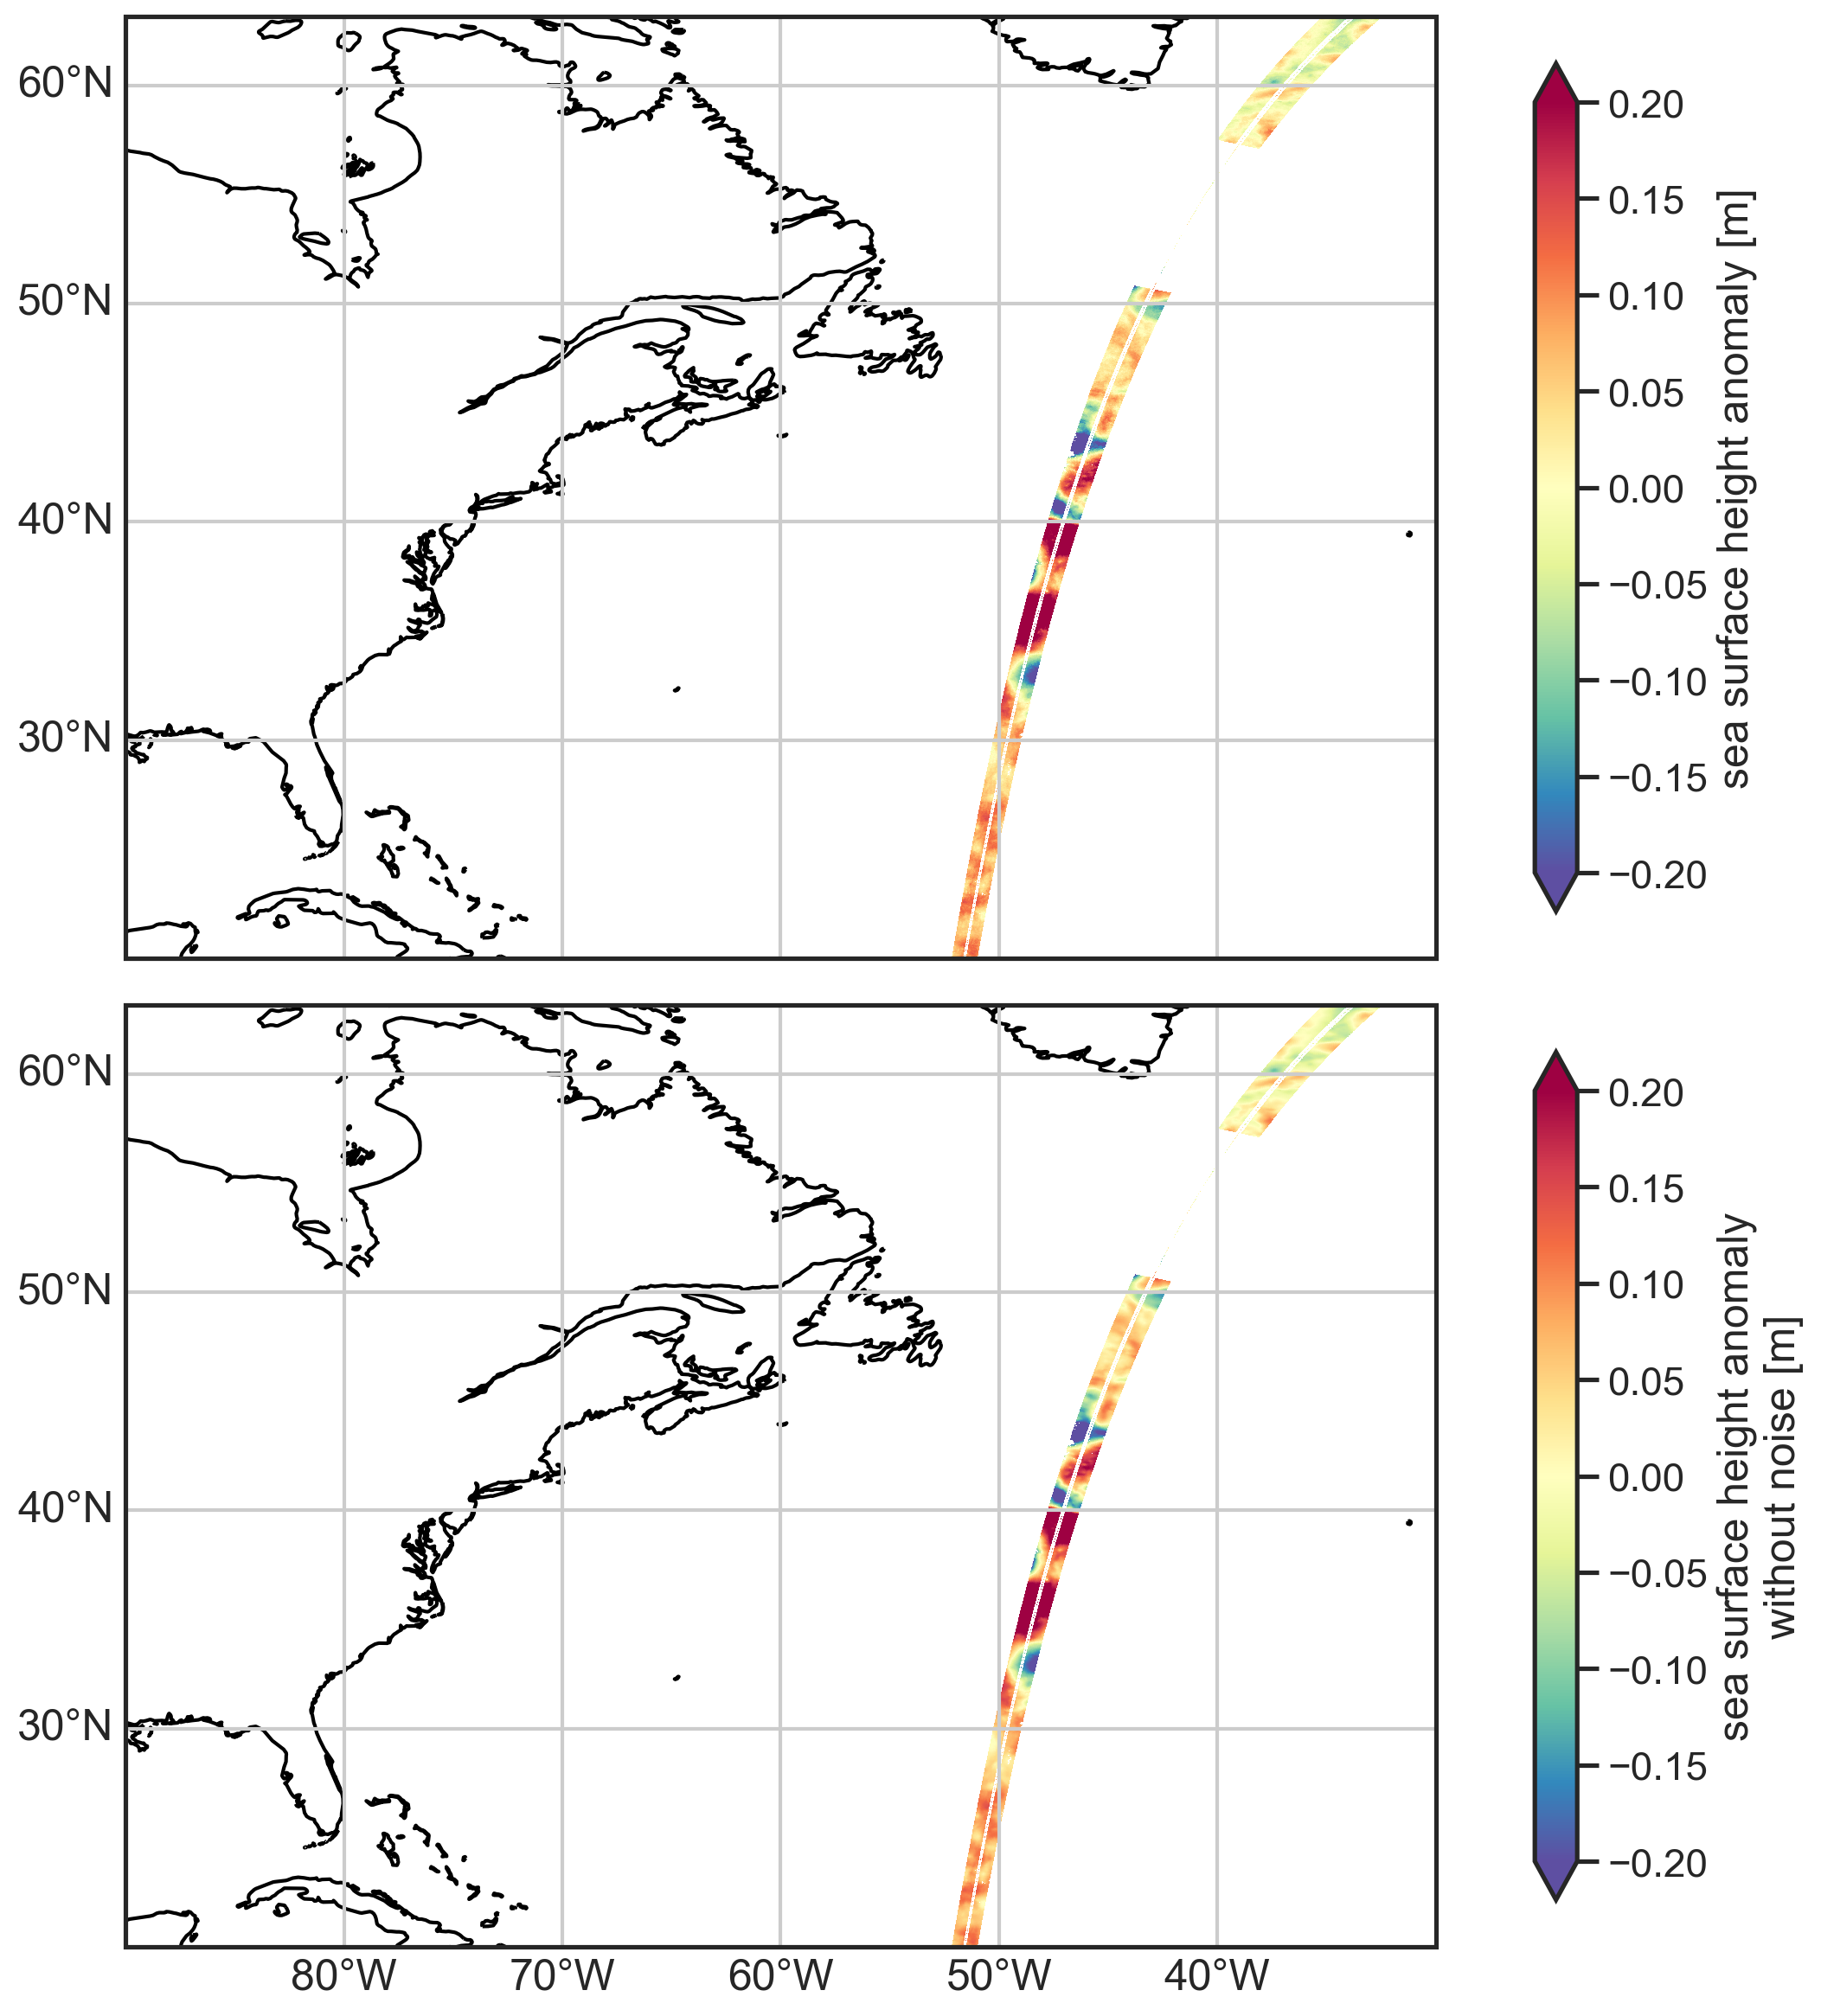

In [10]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

localbox = [-90, -30, 20, 60]
localbox_subset = [-49, -41, 44, 50]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), 
                               subplot_kw={"projection": ccrs.PlateCarree()})
ax1.set_extent(localbox)
ax2.set_extent(localbox)
plot_kwargs = {
    "x": "longitude",
    "y": "latitude",
    "cmap": "Spectral_r",
    "vmin": -0.2,
    "vmax": 0.2,
    "cbar_kwargs": {"shrink": 0.9},}

# Plot SSHA with and without noise removal
ds.ssha.plot.pcolormesh(ax=ax1, **plot_kwargs)
ds.ssha_noiseless.plot.pcolormesh(ax=ax2, **plot_kwargs)
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
gl1.bottom_labels = False
ax2.coastlines()
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False

plt.tight_layout()

## Plot the zonal geostrophic velocity

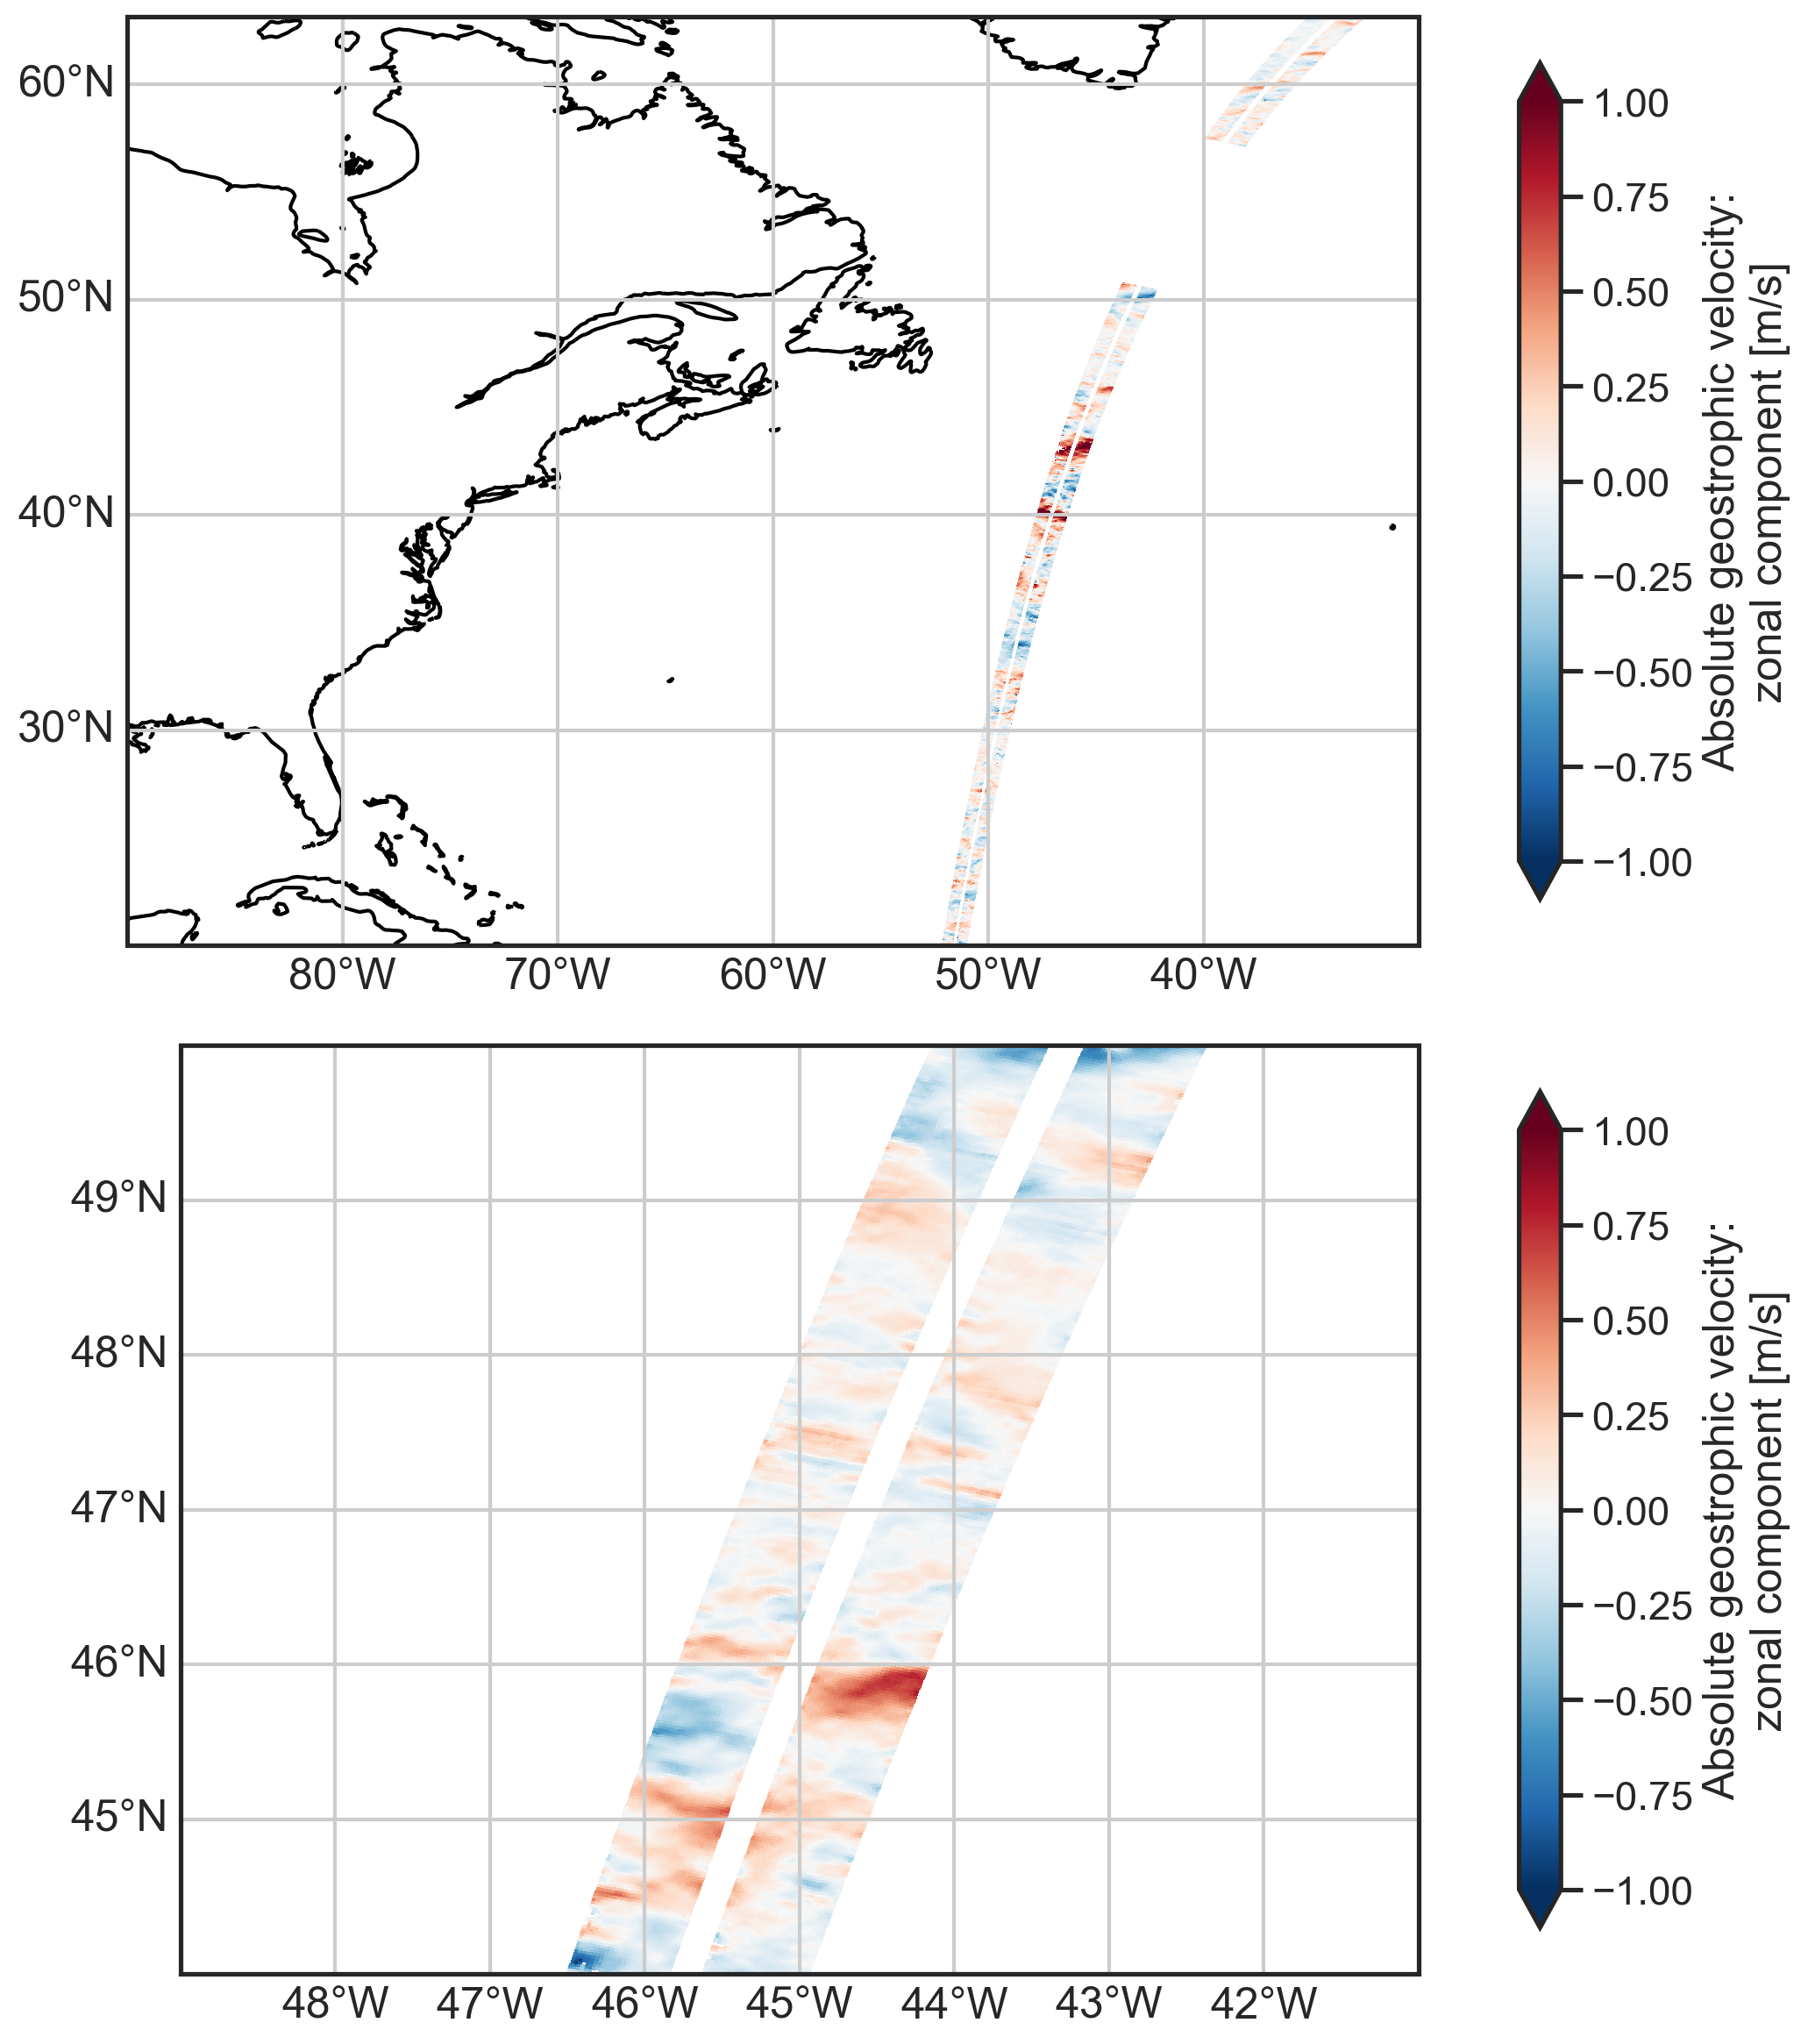

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), 
                               subplot_kw={"projection": ccrs.PlateCarree()})
ax1.set_extent(localbox)
ax2.set_extent(localbox_subset)
plot_kwargs = {
    "x": "longitude",
    "y": "latitude",
    "cmap": "RdBu_r",
    "vmin": -1,
    "vmax": 1,
    "cbar_kwargs": {"shrink": 0.9},}

# Plot geostrophic zonal velocity in large and small domains
ds.ugos.plot.pcolormesh(ax=ax1, **plot_kwargs)
ds.ugos.plot.pcolormesh(ax=ax2, **plot_kwargs)
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
ax2.coastlines()
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False

plt.tight_layout()

## Calculate the velocity-based structure functions

We'll calculate multiple types of structure functions here, including traditional 2nd (`SF_LL`) and 3rd (`SF_LLL`) order and advective structure functions (`SF_advection_velocity`). We calculate the structure functions in two directions, across the swath (`_x`) and along the swath (`_y`). FluidSF also calculates the separation distances in both directions (`x-diffs` and `y-diffs`).

In [12]:
import warnings

import fluidsf

warnings.filterwarnings("ignore") # Ignore warnings for the purpose of this tutorial

# Subset the data to a smaller region
ds_cut = ds.where(
            (ds.latitude > localbox_subset[2])
            & (ds.latitude < localbox_subset[3])
            & (ds.longitude < 360+localbox_subset[1])
            & (ds.longitude > 360+localbox_subset[0]),
            drop=True,
        )

# Define the grid spacing in meters
dx = 2000 
dy = 2000

# Define x and y positions based on number of pixels and lines and dx/dy
x = dx * ds_cut.num_pixels.values
y = dy * ds_cut.num_lines.values

# Compute the structure functions
sf = fluidsf.generate_structure_functions(u = ds_cut.ugos.data, v = ds_cut.vgos.data, 
                                          x = x, y = y, traditional_type=["LLL", "LL"], 
                                          boundary=None, grid_type="uniform")

Check which keys have data in the `sf` dictionary. Other keys are available but have been initialized to `None`.

In [13]:
for key in sf.keys():
    if sf[key] is not None:
        print(key)

SF_advection_velocity_x
SF_advection_velocity_y
SF_LL_x
SF_LL_y
SF_LLL_x
SF_LLL_y
x-diffs
y-diffs


## Estimate cascade rates with the structure functions

In [14]:
sf['SF_LLL_x_epsilon'] = sf["SF_LLL_x"]/(3*sf["x-diffs"]/2)
sf['SF_LLL_y_epsilon'] = sf["SF_LLL_y"]/(3*sf["y-diffs"]/2)

sf['SF_advection_velocity_x_epsilon'] = sf["SF_advection_velocity_x"]/2
sf['SF_advection_velocity_y_epsilon'] = sf["SF_advection_velocity_y"]/2

## Plot the cascade rates

We computed two types of structure functions (advective and traditional 3rd order) in the across-track (`x`) and along-track (`y`) directions, so we will plot 4 different estimates of the cascade rate as a function of separation distance (in km).

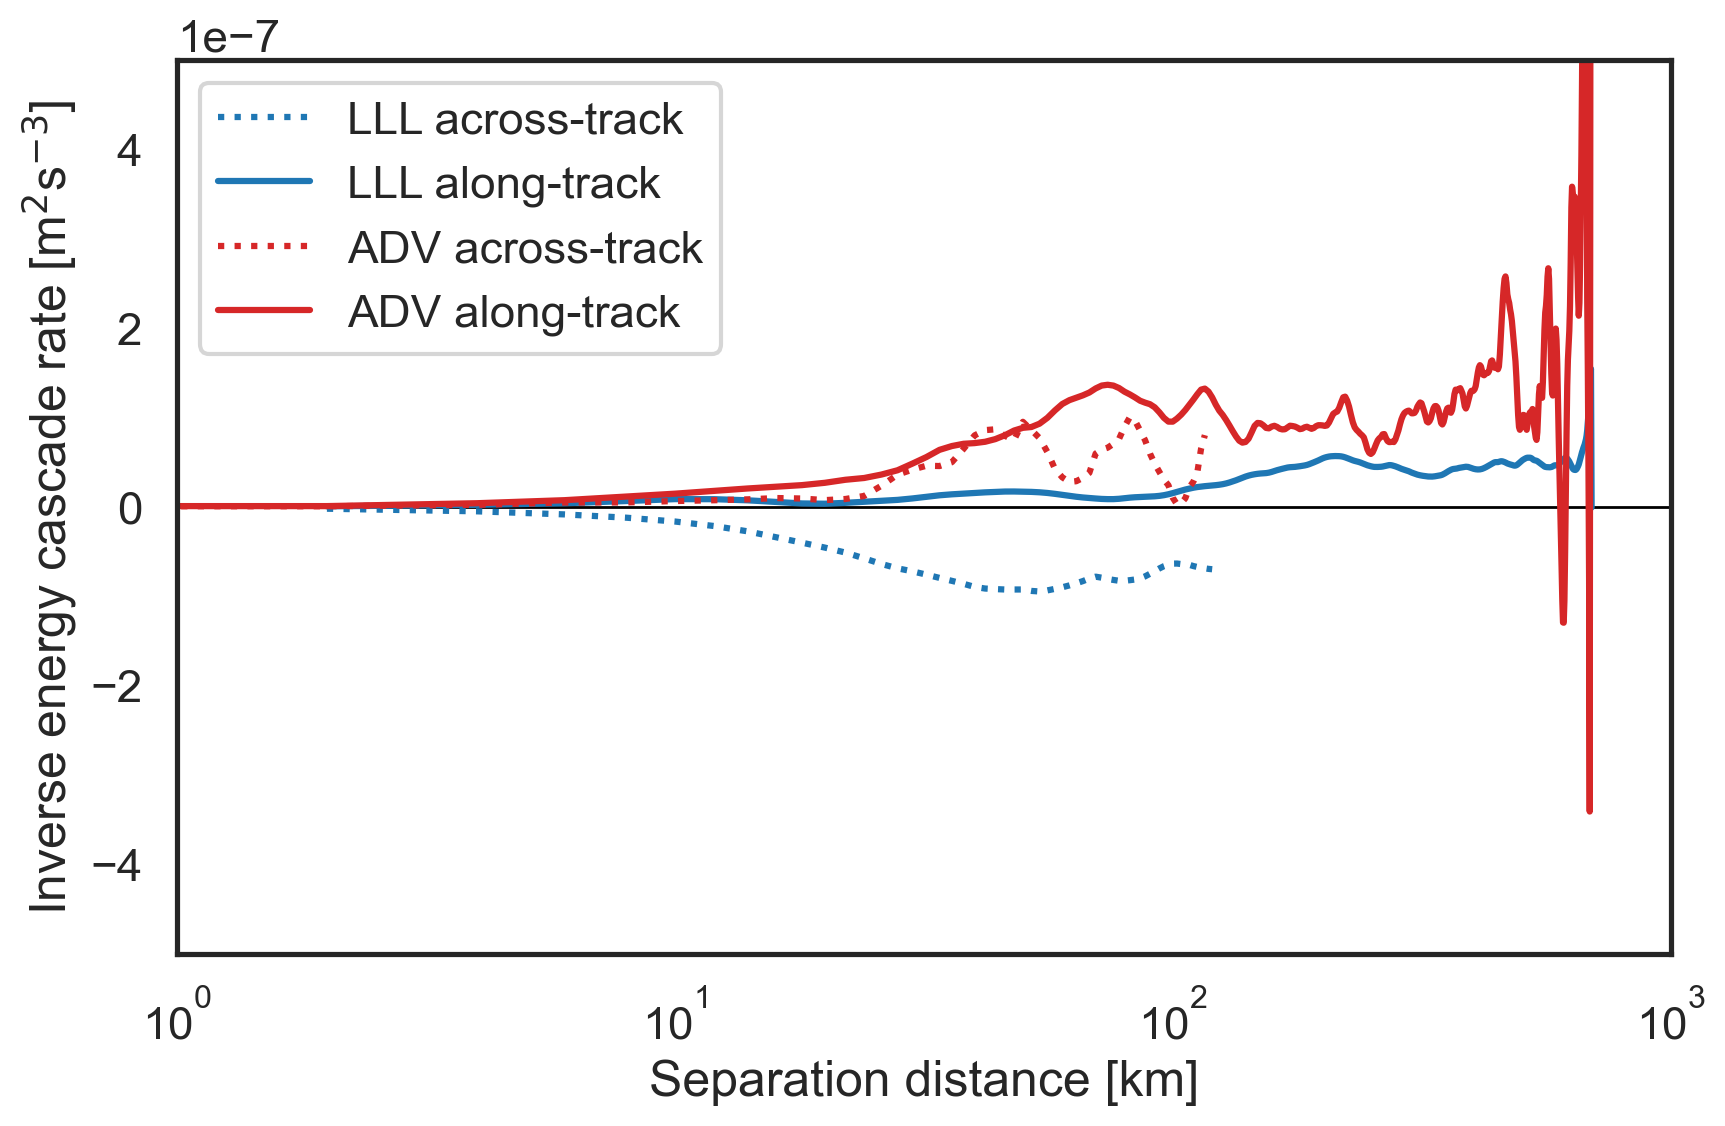

In [15]:
fig, ax = plt.subplots(figsize=(9,6))

# Plot the cascade rates derived from traditional third order structure functions
plt.semilogx(sf["x-diffs"]/1e3, sf['SF_LLL_x_epsilon'], label="LLL across-track",
             color='tab:blue', linestyle=':')
plt.semilogx(sf["y-diffs"]/1e3, sf['SF_LLL_y_epsilon'], label="LLL along-track", 
             color='tab:blue', linestyle='-')

# Plot the cascade rates derived from advective structure functions
plt.semilogx(sf["x-diffs"]/1e3, sf['SF_advection_velocity_x_epsilon'], 
             label="ADV across-track", color='tab:red', linestyle=':')
plt.semilogx(sf["y-diffs"]/1e3, sf['SF_advection_velocity_y_epsilon'], 
             label="ADV along-track", color='tab:red', linestyle='-')

plt.hlines(0, 1e0, 1e3, lw=1, color="k",zorder=0)
plt.xlim(1e0, 1e3)
plt.ylim(-5e-7, 5e-7)
plt.xlabel("Separation distance [km]")
plt.ylabel(r"Inverse energy cascade rate [m$^2$s$^{-3}$]")
plt.legend()

plt.tight_layout()

## Plot the 2nd order traditional structure functions
These structure functions are related to the energy spectrum and are therefore also useful for analysis. 

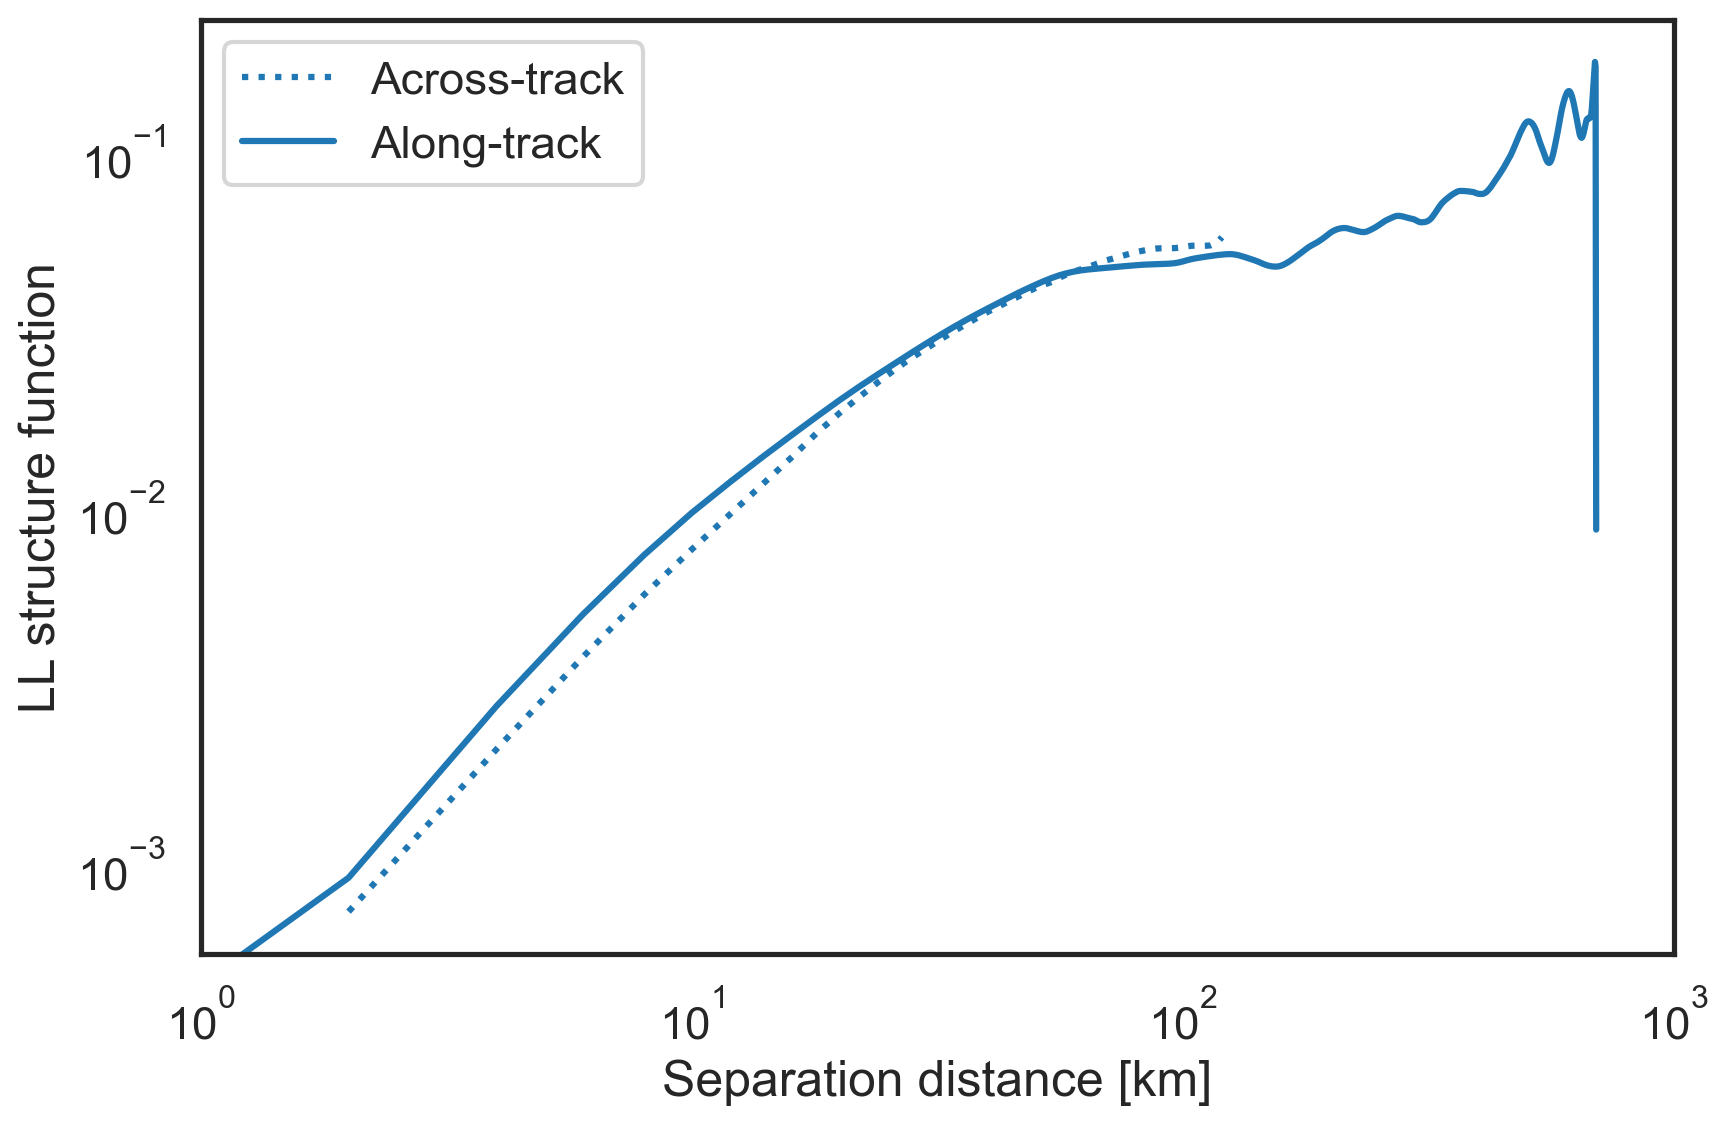

In [16]:
fig, ax = plt.subplots(figsize=(9,6))


plt.loglog(sf["x-diffs"][1:]/1e3, sf['SF_LL_x'][1:], label="Across-track",
           color='tab:blue', linestyle=':')
plt.loglog(sf["y-diffs"]/1e3, sf['SF_LL_y'], label="Along-track",
           color='tab:blue', linestyle='-')

plt.xlim(1e0, 1e3)
plt.xlabel("Separation distance [km]")
plt.ylabel("LL structure function")
plt.legend()

plt.tight_layout()

## Binned structure functions

You can also provide an argument to `fluidsf.generate_structure_functions()` that bins the data. This may be useful when you have more data in one direction.

In [17]:
sf_binned = fluidsf.generate_structure_functions(u = ds_cut.ugos.data, 
                                                 v = ds_cut.vgos.data, 
                                                 x = x, y = y, 
                                                 traditional_type=["LLL", "LL"], 
                                                 boundary=None, grid_type="uniform", 
                                                 nbins=20)

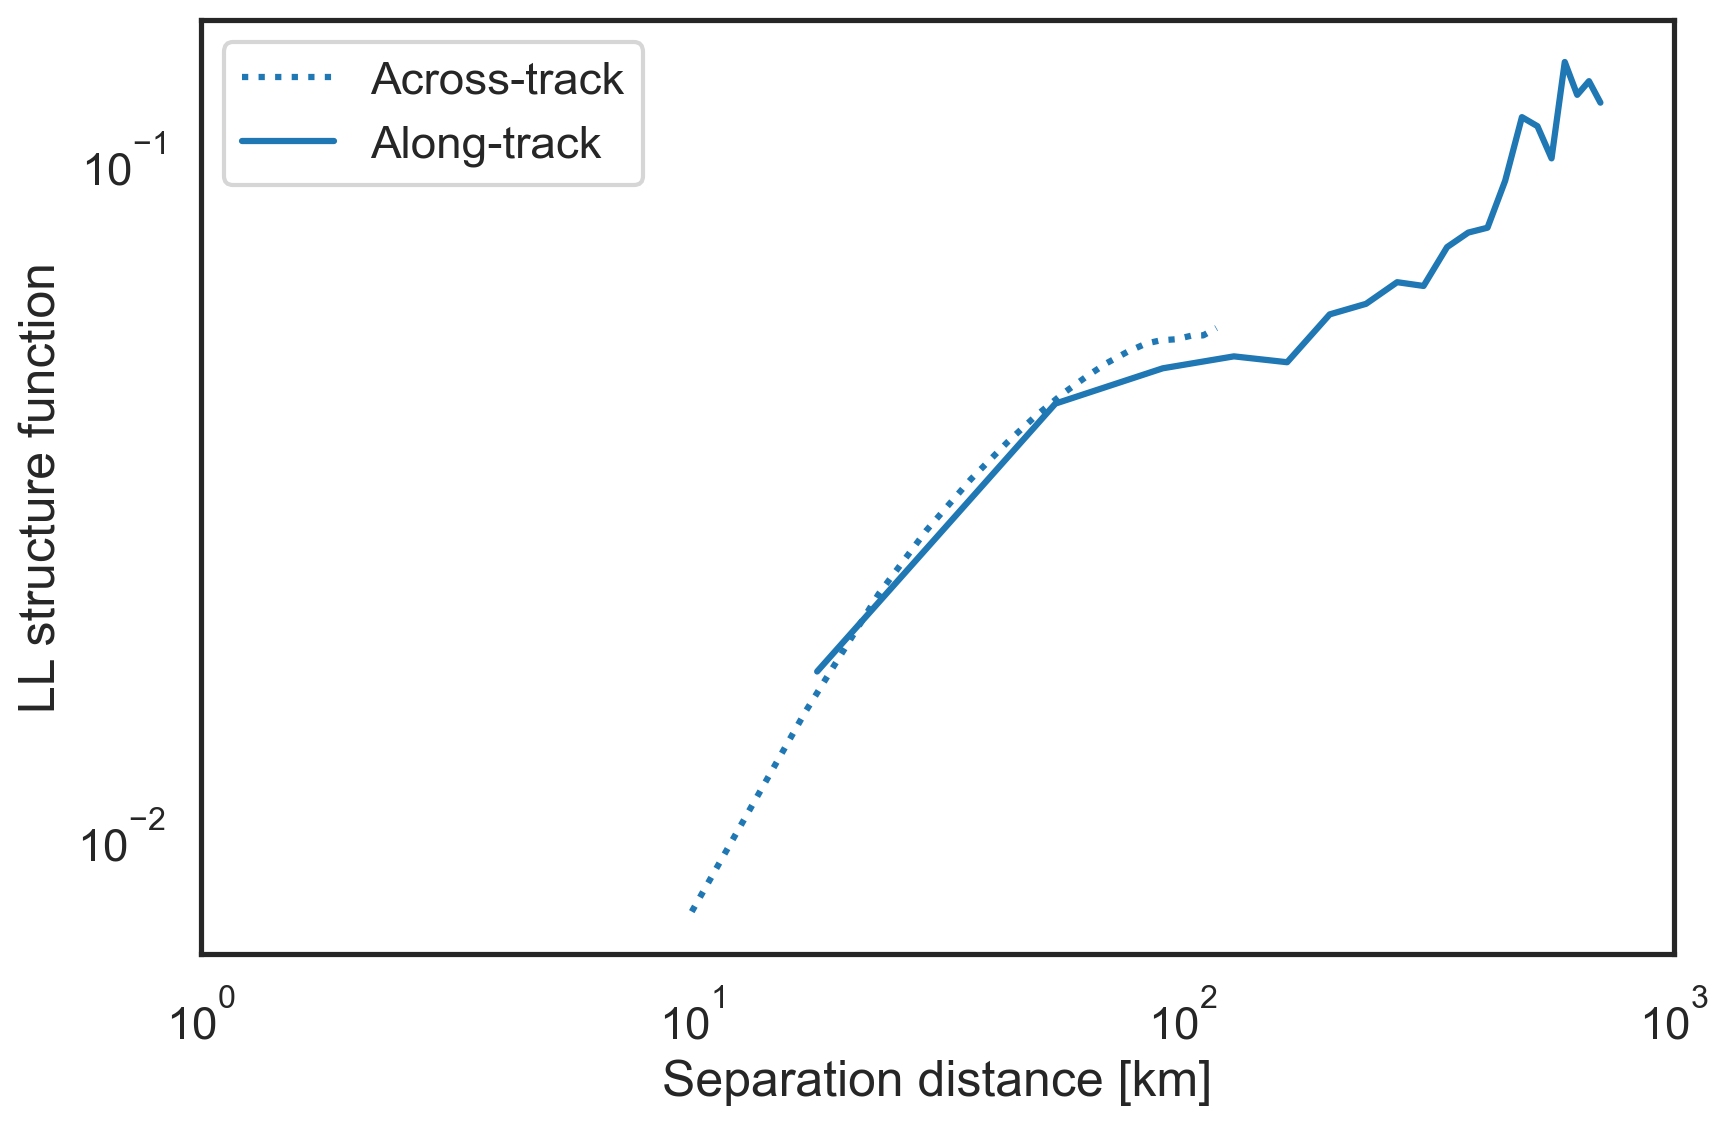

In [18]:
fig, ax = plt.subplots(figsize=(9,6))


plt.loglog(sf_binned["x-diffs"][1:]/1e3, sf_binned['SF_LL_x'][1:], label="Across-track",
           color='tab:blue', linestyle=':')
plt.loglog(sf_binned["y-diffs"]/1e3, sf_binned['SF_LL_y'], label="Along-track",
           color='tab:blue', linestyle='-')

plt.xlim(1e0, 1e3)
plt.xlabel("Separation distance [km]")
plt.ylabel("LL structure function")
plt.legend()

plt.tight_layout()